In [9]:
import numpy as np
import os, sys
import glob
import scipy
from scipy import ndimage
import run_LF as LF

# Plotting
import matplotlib.pylab as plt
import matplotlib as mpl

%matplotlib inline

# Colors
plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

from astropy.cosmology import Planck15
import astropy.units as u
from astropy.cosmology import z_at_value

# Make reionization history plot

## Plot setup

In [4]:
label_z    = 'Redshift, z'
label_xHI  = r'IGM neutral fraction, $\overline{x}_\mathrm{HI}$'

def plt_errorbar_obs(x, y, xerr=None, yerr=None,
                 uplims=None, lolims=None, 
                 marker='o', ms=15, ls='None',
                 col='0.3', mfc='w',
                 mew=1.2, elw=1.2, capsize=2.,
                 label=None, zorder=15):
    
    ln = plt.errorbar(x, y, yerr=yerr, xerr=xerr,
                 uplims=uplims, lolims=lolims, 
                 marker=marker, ms=ms, 
                 capsize=capsize, mew=mew,
                 color=col, mfc=mfc, mec=col, 
                 elinewidth=elw, ls=ls, 
                 label=label, zorder=zorder)
    
    return ln

def plt_obs_list(obs, col='0.3', mfc='w', 
                 lw=1.2, zorder=15):
    
    for i, ob in enumerate(obs):
    
        yerrs  = np.array(ob['xHI_err'])

        # Limits
        lims = np.array(ob['lim'])
        uplims = (lims == 'up')
        lolims = (lims == 'low')

        yerrs[0][uplims] = 0.15
        try:
            yerrs[0][np.where(ob['xHI'][uplims] < 0.1)] = 0.05
        except:
            pass
        yerrs[1][lolims] = 0.15

        # z_err
        try:
            xerrs = ob['z_err']
        except:
            xerrs = None

        plt_errorbar_obs(x=ob['z'], y=ob['xHI'], 
                         yerr=yerrs, xerr=xerrs, 
                         col=col, mfc=mfc,
                         uplims=uplims, lolims=lolims,
                         marker=ob['sym'], ms=ob['s']-5,
                         mew=lw, elw=lw, 
                         label=ob['lab'],
                         zorder=zorder)
        # Error bars
        plt_errorbar_obs(x=ob['z'], y=ob['xHI'], 
                         yerr=yerrs, xerr=xerrs, col=col,
                         mew=lw, elw=lw, 
                         marker=None, zorder=zorder)

    return

def make_Gyr_axis(ax1, age_list=[0.1, 0.2, 0.3, 0.5, 1., 2., 13.], fontsize=10):
    ax2 = ax1.twiny()
    ages     = np.array(age_list)*u.Gyr
    ageticks = [z_at_value(Planck15.age, a) for a in ages]#[::-1]

    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age.value) for age in ages])
    ax2.minorticks_off()
    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xlabel('Gyr since Big Bang', fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', pad=3)
    ax1.tick_params(axis='both', which='major', pad=3)

    return

# Reionization history constraints

In [5]:
# Morales+20
lya_xHI_posterior =  {'z':[6.6,7.3, 7.0], 
                   'xHI':np.array([0.07, 0.766, 0.208]), 
                   'xHI_err':np.array([[0., 0.1, 0.047],[0.,0.112,0.052]]),
                   'lim':['up',False, False],
                   'sym':'H', 's':11, 'lab':r'Ly$\alpha$ LF - This Work (1$\sigma$)'}

# # Whitler+19
# lya_EW_scatter =  {'z':[6.9], 'z_err':[0.5], 
#                    'xHI':np.array([0.55]), 
#                    'xHI_err':np.array([[0.13],[0.11]]),
#                    'lim':[False],
#                    'sym':'*', 's':20, 'lab':r'Whitler+19 ($\sigma = 0.5$ mag)'}

# Lya EW distribution inference Mason+18a,+19,Hoag+19, Whitler+19 z=6.9 replacement
lya_EW =  {'z':[6.9,7.6,7.8], 'z_err':[0.5,0.6,0.6], 
           'xHI':np.array([0.55,0.88,0.76]), 
           'xHI_err':np.array([[ 0.13,0.10, 0.],[0.11, 0.05, 0.]]),
           'lim':[False,False,'low'],
           'sym':'*', 's':18, 'lab':r'Ly$\alpha$ EW evolution'}

# Clustering from Sobacchi & Mesinger 2015 (of Ouchi+2010)
# x_HI < 0.5
clust = {'z':[6.6], 'xHI':np.array([0.5]), 'xHI_err':[[0.],[0.]], 
         'lim':['up'],
         'sym':'s', 's':13, 'lab':'LAE clustering'} #'Sobacchi+15'}#

# Lya forest dark pixels from McGreer+2015
dark =  {'z':[5.6,5.9,6.1], 
         'xHI':np.array([0.04,0.06,0.38]), 
         'xHI_err':np.array([[0., 0., 0.],[0.05, 0.05, 0.20]]), 
         'lim':['up', 'up', 'up'],
         'sym':'o', 's':13, 'lab':r'Dark fraction'} #'McGreer+15'}#

# QSO damping wings 
# Davies+18  x_HI(z=7.09) = 0.48\pm0.26
#            x_HI(7.54)   = 0.6+0.20-0.23
# Greig+19 x_HI(7.54)   = 0.21+0.17-0.19
damp = {'z':[7.09, 7.54, 7.09, 7.54], 
        'xHI':np.array([0.48, 0.6, 0.40, 0.21]),
        'xHI_err':np.array([[0.26, 0.23, 0.19, 0.19],[0.26, 0.2, 0.21, 0.17]]),
        'lim':[False,False,False,False],
        'sym':'D', 's':11, 'lab':'QSO damping wings'}

xHI_obs = [lya_EW, clust, dark, damp]

## Reionization history model space from Mason+19

In [6]:
xHI_mod_dir = os.environ['LYA_DATA_DIR'] + '/data/models/reionization_history_models/'
xHI_CMB_DF = np.genfromtxt(xHI_mod_dir+'xHI_2obs_regions.txt', names=True)

# Plot reionization history

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


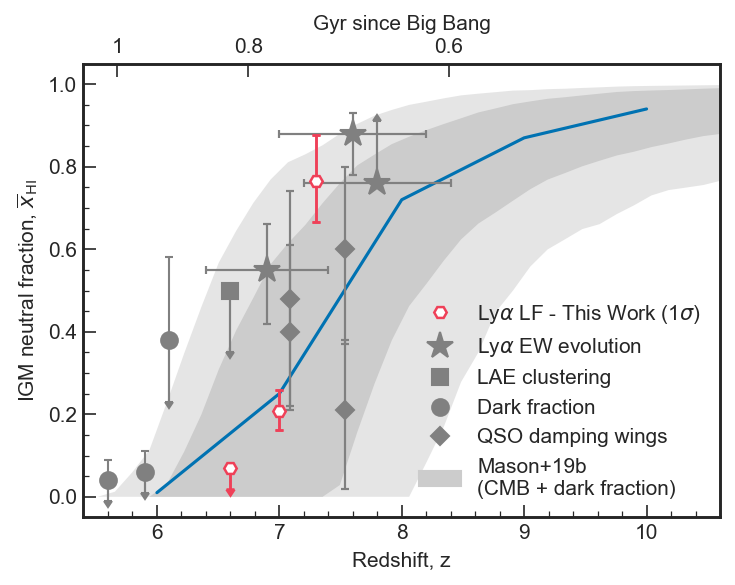

In [100]:

fig, ax = plt.subplots(figsize=(5.,4.), dpi=150)

# =======================
# Plot allowed space from CMB tau and dark pixel fraction
col_M19b   = '0.8'
label_M19b = 'Mason+19b\n(CMB + dark fraction)'
plt.fill_between(xHI_CMB_DF['z'], xHI_CMB_DF['xHI_l95'], xHI_CMB_DF['xHI_u95'], lw=0, color=col_M19b, alpha=0.5)
plt.fill_between(xHI_CMB_DF['z'], xHI_CMB_DF['xHI_l68'], xHI_CMB_DF['xHI_u68'], lw=0, color=col_M19b)


# Patch for legend
ln_2obs = mpl.patches.Patch(color=col_M19b, label=label_M19b)

# =======================
# Plot observations
col_obs = '0.5'
plt_obs_list(xHI_obs, col=col_obs, mfc=col_obs, lw=1)

# # Whitler+19
# col_W19 = '0.5'
# plt_obs_list([lya_EW_scatter], col=col_W19, mfc='w', zorder=100)

#Morales+20
col_M20 = '#EF4058'
plt_obs_list([lya_xHI_posterior], col=col_M20, mfc='w', zorder=100)

plt.plot(zvals,xHI_grid_match)

# =======================
# Legend

# Observed constraints minus errors bars
handles, labels = plt.gca().get_legend_handles_labels()
handles_noeb    = [h[0] for h in handles]

# Add patch
handles_noeb.append(ln_2obs)
labels.append(label_M19b)


# reorder
reorder = [4, 0, 1, 2, 3, 5]
labels  = [labels[i] for i in reorder]
handles_noeb = [handles_noeb[i] for i in reorder]

plt.legend(handles_noeb, labels, numpoints=1, loc='lower right')
# =======================

plt.xlabel(label_z)
plt.ylabel(label_xHI)
ax.set_xlim(5.4, 10.6)
ax.set_ylim(-0.05,1.05)

# Make a Gyr axis?
make_Gyr_axis(ax, age_list=[0.4, 0.6, 0.8, 1.,])
ax.minorticks_on()

plt.tight_layout()
plt.savefig('reionization_history.pdf', bbox_inches='tight')
plt.show()

In [107]:
zvals = np.arange(6.0,11.0)
# print(zvals)
# LF_pred_z= np.array([6.0,7.0,8.0,9.0,10.0])

xHI_interp = scipy.interpolate.interp1d(xHI_CMB_DF['z'],xHI_CMB_DF['xHI_med'])
new_xHIvals = xHI_interp(LF_pred_z)
print(new_xHIvals)

idx = [(np.abs(LF.xHI_list - xHI)).argmin() for xHI in new_xHIvals]
xHI_grid_match = LF.xHI_list[idx]
print(xHI_grid_match)

[0.         0.26361325 0.7127253  0.87908776 0.94068755]
[0.01 0.25 0.72 0.87 0.94]


Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

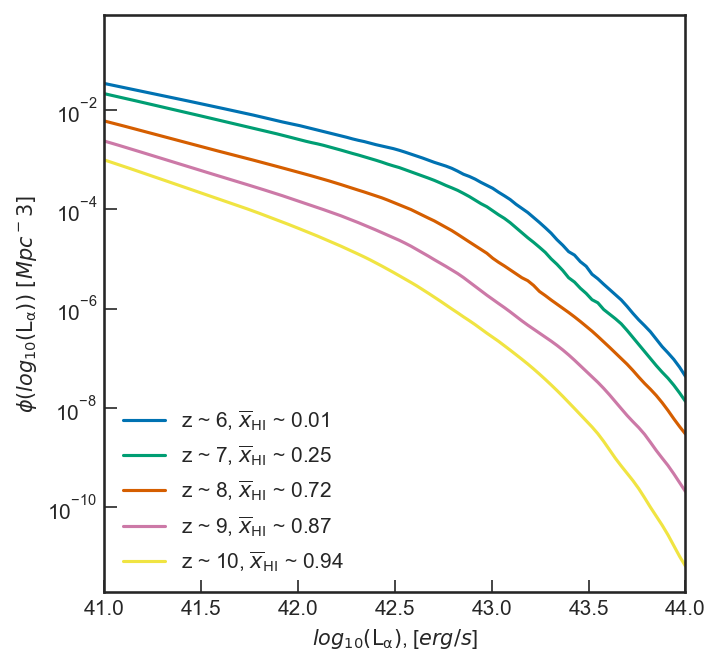

In [110]:
# zvals = xHI_CMB_DF['z'].round(1)
# zvals_index = np.where(zvals == 9.9)[0]
xHIvals = xHI_CMB_DF['xHI_med'].round(2)[70]


LF_pred_xHI = np.array([0.01,0.22,0.69,0.87,0.94])



plt.figure(figsize=(5.,5.), dpi=150)

for z, xHI in zip(zvals,xHI_grid_match):
    label = 'z ~ %.0f'% z + ', '+ '$\overline{x}_\mathrm{HI}$ ~ %.2f'% xHI
    log10_LF_pred = LF.make_lya_LF(zval_test = z ,xHI_test = xHI, F = 0.667, plot=False, log=True)
    plt.semilogy(LF.log10_lg, log10_LF_pred, label = label)

plt.legend()
plt.xlim(41,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('LFpred6to10.pdf', bbox_inches='tight')
# plt.show()